# Heart Disease Dataset Processing and Learning


In [4]:
#data analysis
import numpy as np
import seaborn as sns
import pandas as pd

from pycaret import clustering
from pycaret import classification

from matplotlib import pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

from sklearn import tree 
import graphviz
from sklearn.model_selection import train_test_split , RandomizedSearchCV
import warnings
warnings.filterwarnings("ignore")

In [5]:
heart_dat = pd.read_csv("heart.csv")
heart_dat.head()



Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0

In [6]:
#process the data

#set categorical data to numeric

heart_dat["ST_Slope"] = heart_dat["ST_Slope"].map({"Up" : 0, "Flat" : 1, "Down" : 2})
heart_dat["Sex"] = heart_dat["Sex"].map({"M" : 1, "F" : 0})
heart_dat["RestingECG"] = heart_dat["RestingECG"].map({"ST" : 1, "Normal" : 0})
heart_dat["ExerciseAngina"] = heart_dat["ExerciseAngina"].map({"Y" : 1, "N" : 0})
heart_dat["ChestPainType"] = heart_dat["ChestPainType"].map({"ASY" : 0, "TA" : 1, "ATA" : 1, "NAP" : 2})
#asymptomatic, so no chestpain
#any kind of angina realated pain
#2 for non anginal pain 
print(heart_dat.duplicated().sum())
heart_dat.head()

0


Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  RestingECG  \
0   40    1              1        140          289          0         0.0   
1   49    0              2        160          180          0         0.0   
2   37    1              1        130          283          0         1.0   
3   48    0              0        138          214          0         0.0   
4   54    1              2        150          195          0         0.0   

   MaxHR  ExerciseAngina  Oldpeak  ST_Slope  HeartDisease  
0    172               0      0.0         0             0  
1    156               0      1.0         1             1  
2     98               0      0.0         0             0  
3    108               1      1.5         1             1  
4    122               0      0.0         0             0

<Axes: >

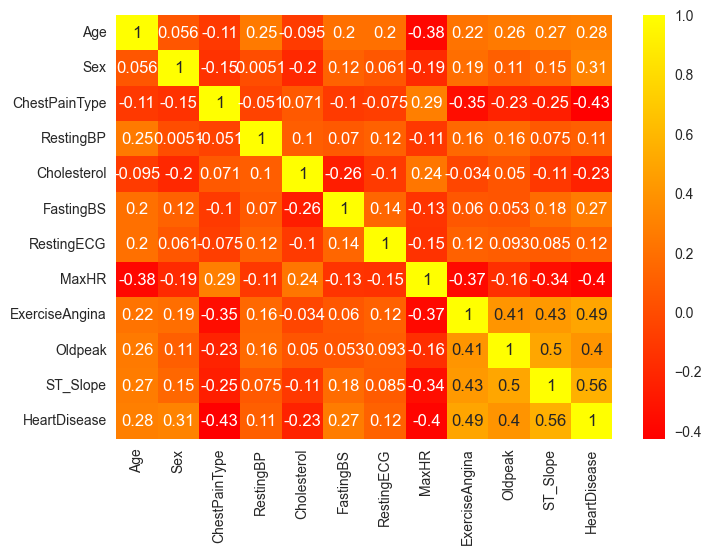

In [7]:
#check correlation
sns.heatmap(heart_dat.corr(), cmap = "autumn", annot = True)

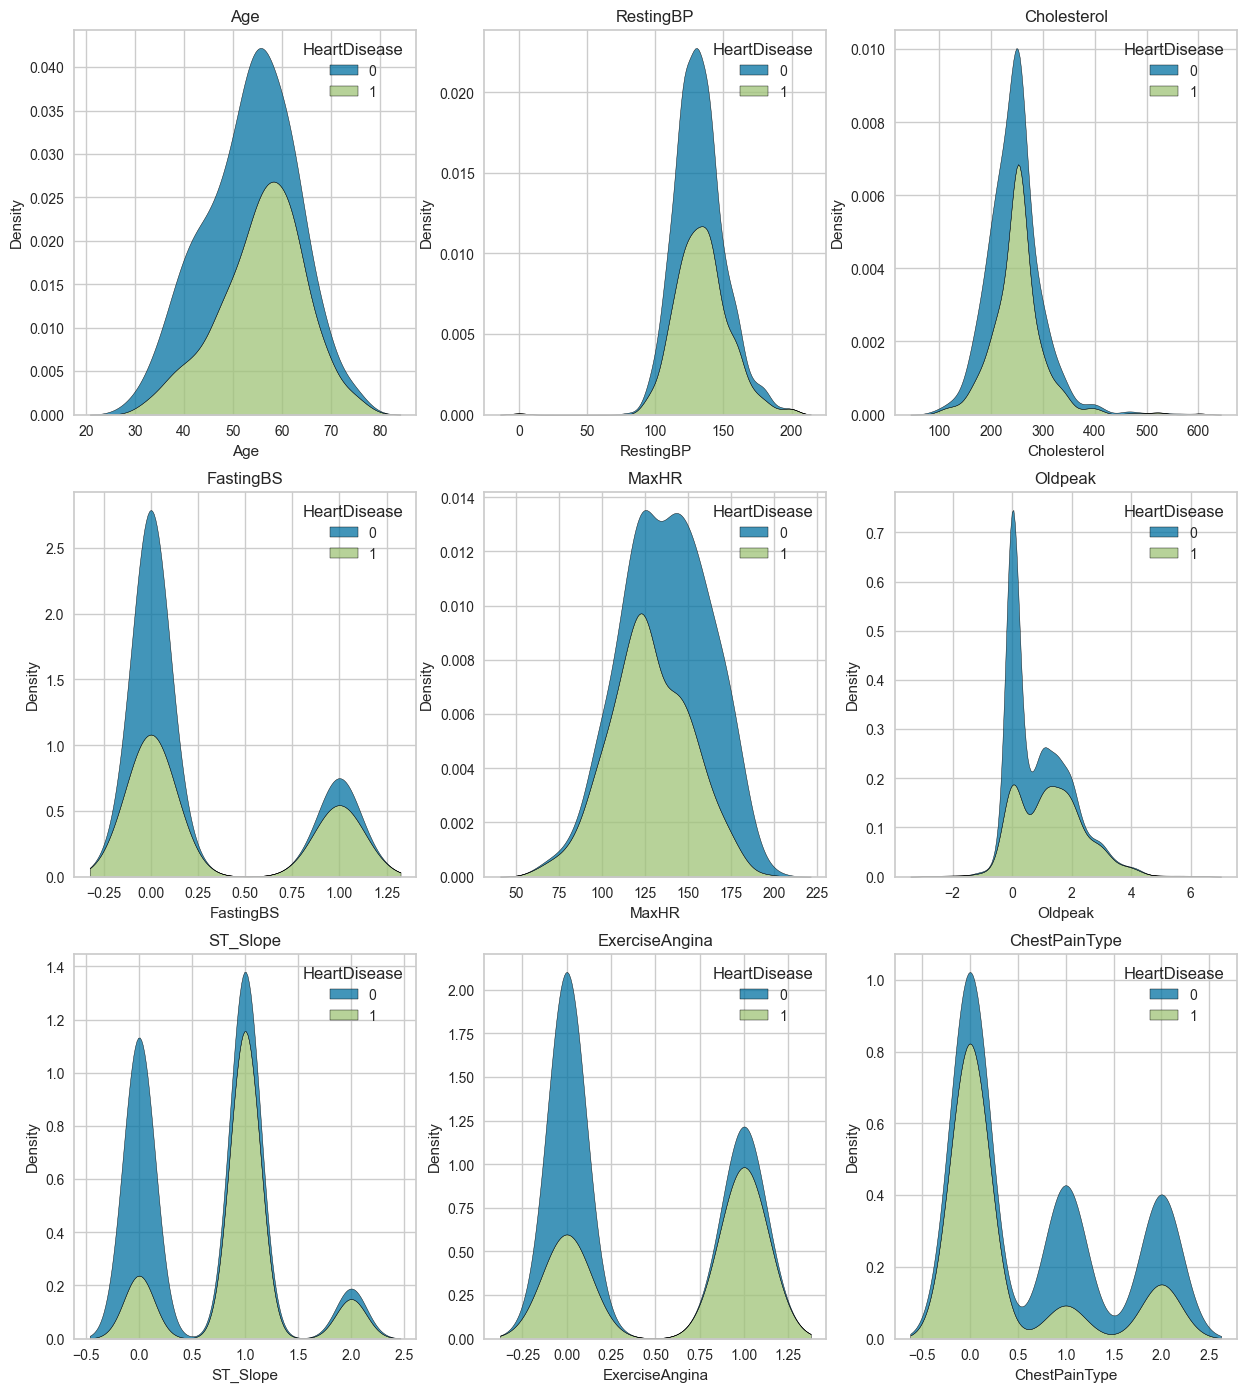

In [12]:
#take a look at the data if we need som fixing
column=['Age','RestingBP','Cholesterol','FastingBS','MaxHR','Oldpeak','ST_Slope','ExerciseAngina','ChestPainType']
plt.figure(figsize=(15,17))
for i,category in enumerate(column):
    plt.subplot(3,3,i+1)
    sns.kdeplot(data=heart_dat, x=heart_dat[category], hue="HeartDisease", multiple="stack")
    plt.title(category)
plt.show()

(fastingBS is categorical > 120)
cholesterol levels have second peak at 0 apart from the normal distribution
Check if the 0 really are null values


In [9]:
try:
    heart_dat.loc[heart_dat["Cholesterol"] < 50 | heart_dat["Cholesterol"] > 0,["Cholesterol"]]
except:
    print("ei välillä 50-0")

ei välillä 50-0


In [10]:
#remove NANs etc...
print(heart_dat.isnull().values.any())

heart_dat = heart_dat.fillna(0)

True


In [11]:
#get the empty cholesterol levels with multiple linear regression
from sklearn.linear_model import LinearRegression

# creating train and test sets
clean_part = heart_dat.loc[heart_dat["Cholesterol"] != 0, :]

X = clean_part.loc[:,["FastingBS","MaxHR","HeartDisease"]]
y = clean_part['Cholesterol']

model = LinearRegression()
model.fit(X,y)

predictions = model.predict(heart_dat.loc[heart_dat["Cholesterol"] == 0, ["FastingBS","MaxHR","HeartDisease"]])
print(np.median(predictions))
print(np.var(predictions))

#get the cholesterol values
p = 0
for n in range(heart_dat.shape[0]):
    if heart_dat._get_value(n,"Cholesterol") == 0:
        heart_dat.loc[n,["Cholesterol"]] = predictions[p]
        p += 1

252.4740456976549
36.48604044518672


In [9]:
#scanle the values
heart_standard = (heart_dat-heart_dat.mean())/heart_dat.std()
#pd.DataFrame(StandardScaler().fit_transform(pca_dat))
#get the eigenvalues of the covariancematrix
eigenvalues, eigenvectors = np.linalg.eig(heart_standard.cov())
print('Eigen values:\n', eigenvalues)
print('Eigen values Shape:', eigenvalues.shape)
print('Eigen Vector Shape:', eigenvectors.shape)

# Index the eigenvalues in descending order
idx = eigenvalues.argsort()[::-1]
 
# Sort the eigenvalues in descending order
eigenvalues = eigenvalues[idx]
 
# sort the corresponding eigenvectors accordingly
eigenvectors = eigenvectors[:,idx]

explained_var = np.cumsum(eigenvalues) / np.sum(eigenvalues)
print("explainded variances:" + str(explained_var))

#after wich we can determine the number of components
#if the varianceratio is equal or above50%
n_components = np.argmax(explained_var >= 0.50) + 1
n_components

Eigen values:
 [3.35190726 0.36188392 0.43721162 0.51436832 0.59269913 1.2113205
 1.15147079 1.02874194 0.73737206 0.9123159  0.84042445 0.86028409]
Eigen values Shape: (12,)
Eigen Vector Shape: (12, 12)
explainded variances:[0.27932561 0.38026898 0.47622488 0.56195338 0.6379797  0.70967004
 0.77970541 0.84115308 0.89054468 0.9334087  0.96984301 1.        ]


4

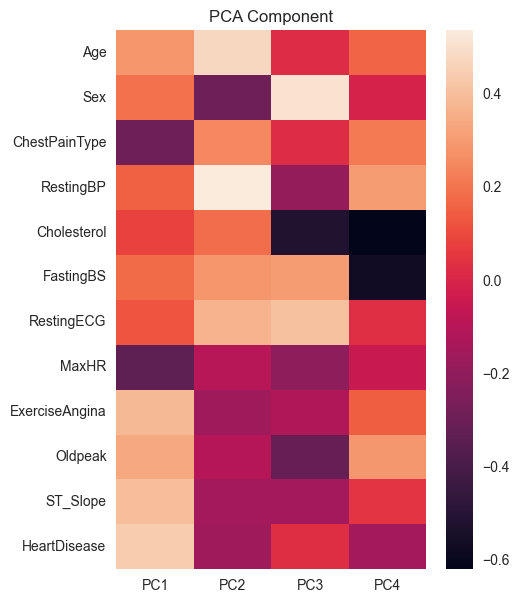

In [10]:
# PCA component or unit matrix
u = eigenvectors[:,:n_components]
pca_component = pd.DataFrame(u,
                             index = list(heart_dat.columns),
                             columns = ["PC1","PC2","PC3","PC4"]
                            )
 
# plotting heatmap
plt.figure(figsize =(5, 7))
sns.heatmap(pca_component)
plt.title('PCA Component')
plt.show()

In [11]:
heart_pca = heart_standard @ pca_component
 
heart_pca = pd.DataFrame(heart_pca.values,
                     columns = ['PCA1','PCA2','PCA3','PCA4']
                            )
heart_pca.head()

PCA1      PCA2      PCA3      PCA4
0 -2.420037 -0.283972 -0.423396 -0.534056
1 -0.924592  0.798542 -1.125106  1.557878
2 -1.305447  0.467251  1.367193 -0.450331
3  1.224539 -0.576279 -1.289348  0.795244
4 -1.760277  0.892202  0.856194  1.308381

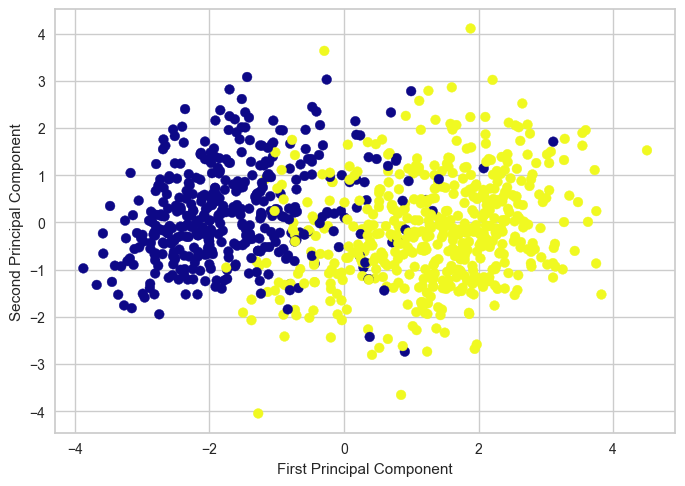

In [12]:
#PCA
#PCA test

pca = PCA(n_components = n_components)

#take principal components
x_pca = pca.fit_transform(heart_standard)

df_pca1 = pd.DataFrame(x_pca, columns=['PC{}'.format(i+1) for i in range(n_components)])
df_pca1.head()

ratios = list(pca.explained_variance_ratio_)

#get the two top components of most variance
top = ratios
top_index = [0,1]
for n in range(len(ratios)):
    if ratios[n] >= top[0]:
        top_index[0] = n
    elif ratios[n] >= top[1]:
        top_index[1] = n
        
#draw plots of the reducted data
plt.scatter(x_pca[:,top_index[0]],x_pca[:,top_index[1]], c = heart_dat["HeartDisease"], cmap = "plasma")
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

Cluster the heart disease data


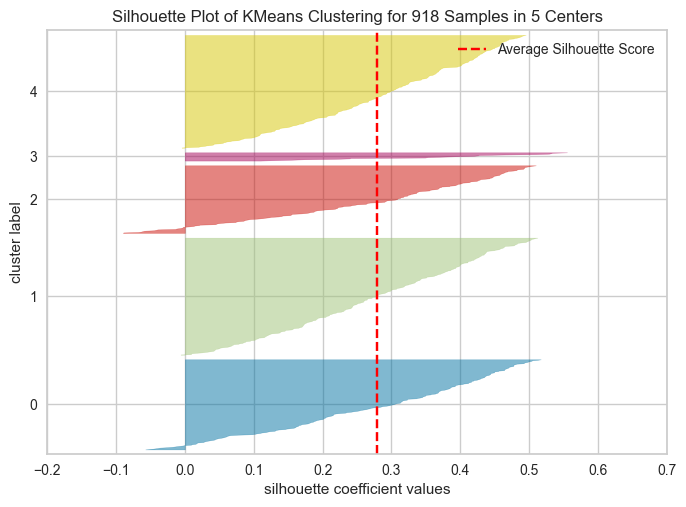

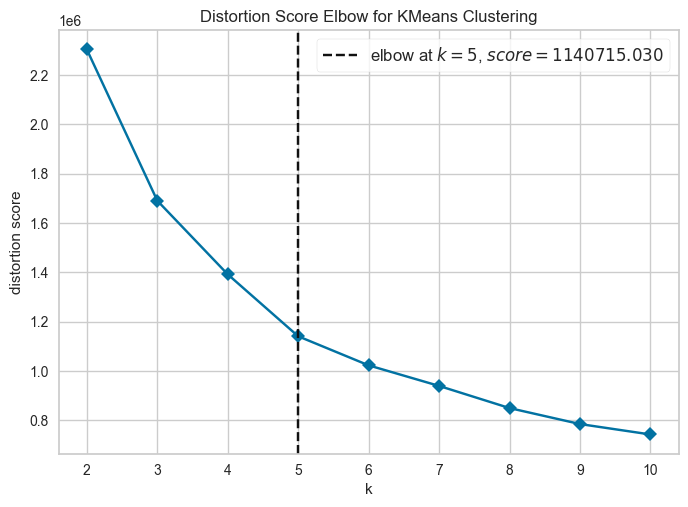

In [13]:
#clustering
s = clustering.setup(heart_dat)

kmeans = clustering.create_model('kmeans', num_clusters=5)

clustering.plot_model(kmeans, plot = 'silhouette')
clustering.plot_model(kmeans, plot = 'elbow')
clustering.plot_model(kmeans, plot = 'cluster')


In [46]:
clustering.plot_model(kmeans, plot = "distribution", feature = "ST_Slope")
clustering.plot_model(kmeans, plot = "distribution", feature = "MaxHR")
clustering.plot_model(kmeans, plot = "distribution", feature = "FastingBS")



Run classification for the dataset


In [47]:
sc = classification.setup(heart_dat, target='HeartDisease', normalize = True, transformation=True, session_id=42)


#get the best model
best_model = classification.compare_models()


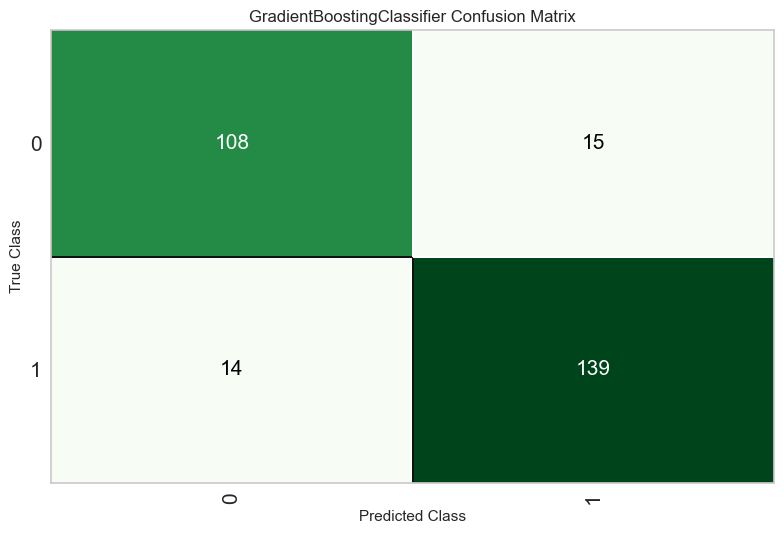

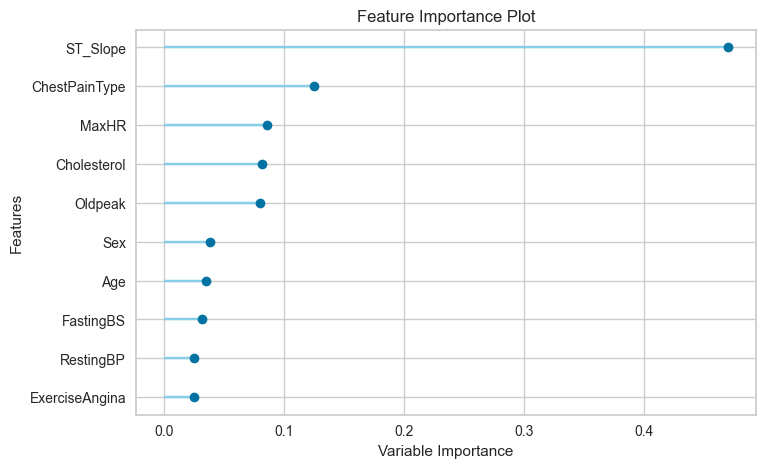

In [48]:
gbc = classification.create_model('gbc', round = 3)
classification.plot_model(gbc, plot = 'confusion_matrix')
classification.plot_model(gbc, plot = 'feature')

From the confusionmatrix we can see the gradienboosting classifier has given quite accurate prediction of heart disease. However we do need to be cautious since our st-slope is valued between -1 and 1. On the other hand high importance makes sense from the kdeplots. we can see that almost all st-slope = 0 to heart disease would give little false positives relative to false ones. We can try random forest asswell.


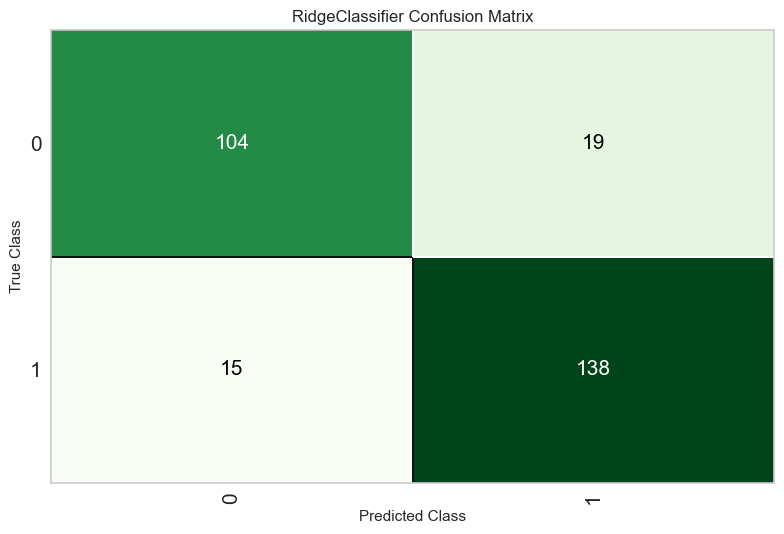

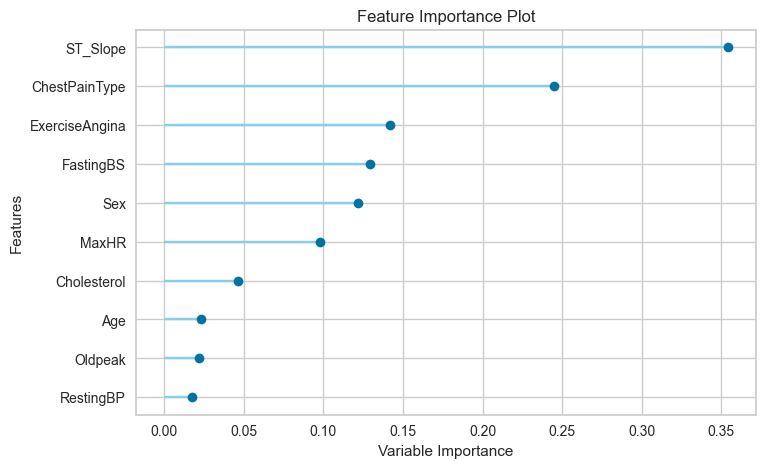

In [49]:
ridge = classification.create_model('ridge', round = 3)
classification.plot_model(ridge, plot = 'confusion_matrix')
classification.plot_model(ridge, plot = 'feature')

We can compare the pc's colored by ST_Slope and HearDisease. We may see a clear correlation with ST_slope being 1 or 2 being a clear indicator that the patient in deed does have heartdisease. It explains why different classification software almost solely use the ST_Slope to predict heart disease.

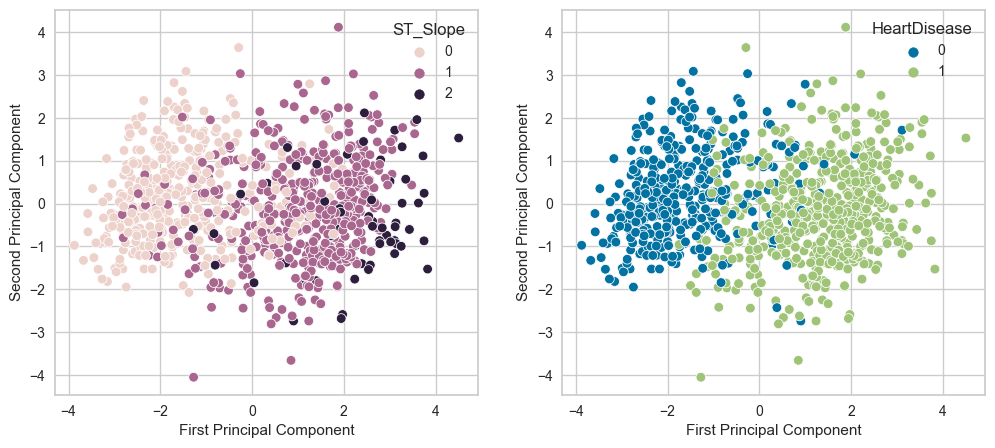

In [28]:
plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
sns.scatterplot(x = x_pca[:,top_index[0]],y = x_pca[:,top_index[1]], hue = heart_dat["ST_Slope"], cmap = "autumn")
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

plt.subplot(1,2,2)
sns.scatterplot(x=x_pca[:,top_index[0]],y=x_pca[:,top_index[1]], hue = heart_dat["HeartDisease"], cmap = "autumn")
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()


In [54]:
#dividing the data into depenedent and independent variables
xt = heart_dat.drop(['HeartDisease'],axis=1)
yt = heart_dat['HeartDisease']

#divide the data into train,test and split
x_train,x_test,y_train,y_test = train_test_split(xt,yt,random_state=2,test_size=0.2)

#building DecisionTree model with Hyperparameter tuning
parameters = {
              "criterion":("gini","entropy"),
              "splitter":("best","random"),
              "max_depth":(3,5,7,10,11,12),
              "min_samples_split":(2,4,6),
              "max_features":("sqrt","log2","auto"),
             }

DT_grid = RandomizedSearchCV(tree.DecisionTreeClassifier(),param_distributions= parameters, cv=5 , verbose=True)
DT_grid.fit(x_train,y_train)

#get estimator
DT_grid.best_estimator_

#construct model
DT_model = tree.DecisionTreeClassifier(criterion="gini", 
                                  splitter="best", 
                                  max_depth=3, 
                                  min_samples_split=2, 
                                  min_samples_leaf=1, 
                                  min_weight_fraction_leaf=0.0, 
                                  max_features='sqrt', 
                                  random_state=None, 
                                  max_leaf_nodes=None, 
                                  min_impurity_decrease=0.0, 
                                  class_weight=None, 
                                  ccp_alpha=0.0 )

DT_model.fit(x_train,y_train)

print (f'Train Accuracy - : {DT_model.score(x_train,y_train):.3f}')
print (f'Test Accuracy - : {DT_model.score(x_test,y_test):.3f}')


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Train Accuracy - : 0.800
Test Accuracy - : 0.723


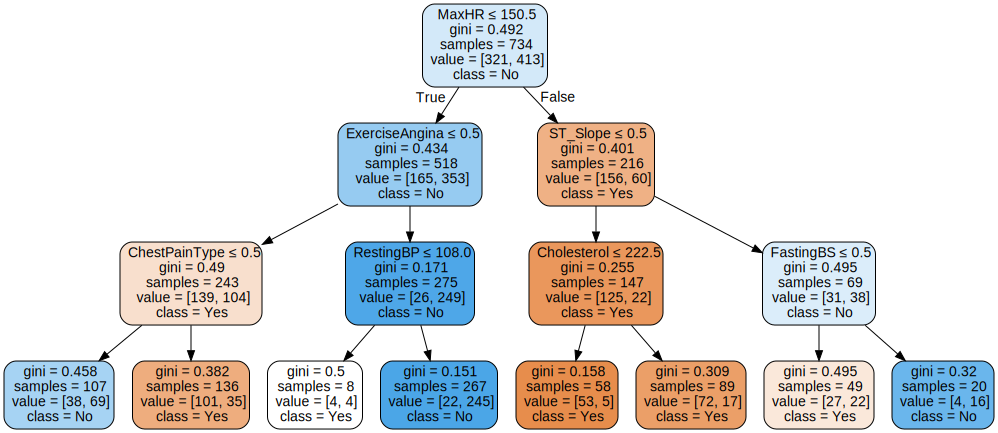

In [55]:
tree_data = tree.export_graphviz(DT_model,
                           out_file=None,
                           feature_names=xt.columns,  #x column names
                           class_names=['Yes','No'], #target variables
                           filled=True,rounded=True, #controls the looks of the nodes and colors it
                           special_characters=True)

graph = graphviz.Source(tree_data)
graph

In [ ]:
var = '''
░░░░░░▄▄▄░░▄██▄
░░░░░▐▀█▀▌░░░░▀█▄
░░░░░▐█▄█▌░░░░░░▀█▄
░░░░░░▀▄▀░░░▄▄▄▄▄▀▀
░░░░▄▄▄██▀▀▀▀
░░░█▀▄▄▄█░▀▀
░░░▌░▄▄▄▐▌▀▀▀
▄░▐░░░▄▄░█░▀▀ SINUT ON SÄIKYTTÄNYT
▀█▌░░░▄░▀█▀░▀
░░░░░░░▄▄▐▌▄▄
░░░░░░░▀███▀█░▄
░░░░░░▐▌▀▄▀▄▀▐▄ KUUMOITTAVA LUURANGSMAN
░░░░░░▐▀░░░░░░▐▌
░░░░░░█░░░░░░░░█
░░░░░▐▌░░░░░░░░░█
░░░░░█░░░░░░░░░░▐▌OPETTELE LASKENNALLISTA BIOLÄÄKETIEDETTÄ, TAI LUURENGOT SYÖVÄT"
'''